In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def plot_market_classification(market_name, X, y_true, model, percentile_range=(5, 95)):
    vol_col = f"{market_name} Volatility"
    growth_col = f"{market_name} Growth"

    if vol_col not in X.columns or growth_col not in X.columns:
        print(f"Market '{market_name}' not found in data.")
        return

    X_market = X[[vol_col, growth_col]].copy()
    # If y_true is a DataFrame (like risk_labels), get the column
    if isinstance(y_true, pd.DataFrame):
      y_market = y_true[market_name].copy()
    # If y_true is a Series (like y_pred_crypto), use it directly
    elif isinstance(y_true, pd.Series):
      y_market = y_true.copy()

    # Align indices to avoid boolean indexing errors
    X_market, y_market = X_market.align(y_market, join='inner', axis=0)

    low_v, high_v = np.percentile(X_market[vol_col], percentile_range)
    low_g, high_g = np.percentile(X_market[growth_col], percentile_range)
    mask = (X_market[vol_col] >= low_v) & (X_market[vol_col] <= high_v) & \
           (X_market[growth_col] >= low_g) & (X_market[growth_col] <= high_g)
    X_market = X_market[mask]
    y_market = y_market[mask]

    clf = HistGradientBoostingClassifier(random_state=42)
    clf.fit(X_market, y_market)

    x_min, x_max = X_market[vol_col].min(), X_market[vol_col].max()
    y_min, y_max = X_market[growth_col].min(), X_market[growth_col].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm", levels=5)

    scatter = plt.scatter(
        X_market[vol_col], X_market[growth_col],
        c=y_market, cmap="coolwarm", edgecolor='k', alpha=0.8
    )
    plt.xlabel("Volatility")
    plt.ylabel("Growth")
    plt.title(f"{market_name}: Risk Classification (True Labels, Outliers Removed)")
    plt.colorbar(scatter, label="Risk Category")
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_market_prediction_vs_truth(market_name, X, y_true, y_pred, percentile_range=(1, 99)):
    vol_col = f"{market_name} Volatility"
    growth_col = f"{market_name} Growth"

    if vol_col not in X.columns or growth_col not in X.columns:
        print(f"Market '{market_name}' not found in data.")
        return

    # Extract relevant data
    X_market = X[[vol_col, growth_col]].copy()

    # Handle Series or DataFrame for both y_true and y_pred
    if isinstance(y_true, pd.DataFrame):
        y_true_market = y_true[market_name].copy()
    else:
        y_true_market = y_true.copy()

    if isinstance(y_pred, pd.DataFrame):
        y_pred_market = y_pred[market_name].copy()
    else:
        y_pred_market = y_pred.copy()

    # Align all three
    y_true_market = y_true_market.reindex(X_market.index)
    y_pred_market = y_pred_market.reindex(X_market.index)

    # Remove outliers
    low_v, high_v = np.percentile(X_market[vol_col], percentile_range)
    low_g, high_g = np.percentile(X_market[growth_col], percentile_range)
    mask = (X_market[vol_col] >= low_v) & (X_market[vol_col] <= high_v) & \
           (X_market[growth_col] >= low_g) & (X_market[growth_col] <= high_g)

    X_filtered = X_market[mask]
    y_true_filtered = y_true_market[mask]
    y_pred_filtered = y_pred_market[mask]

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

    scatter1 = axes[0].scatter(
        X_filtered[vol_col], X_filtered[growth_col],
        c=y_true_filtered, cmap="coolwarm", edgecolor='k', alpha=0.8
    )
    axes[0].set_title(f"{market_name} - True Risk Categories")
    axes[0].set_xlabel("Volatility")
    axes[0].set_ylabel("Growth")

    scatter2 = axes[1].scatter(
        X_filtered[vol_col], X_filtered[growth_col],
        c=y_pred_filtered, cmap="coolwarm", edgecolor='k', alpha=0.8
    )
    axes[1].set_title(f"{market_name} - Predicted Risk Categories")
    axes[1].set_xlabel("Volatility")
    axes[1].set_ylabel("Growth")

    fig.colorbar(scatter2, ax=axes.ravel().tolist(), label="Risk Category")
    fig.suptitle(f"{market_name}: True vs Predicted Risk Categories", fontsize=16)
    plt.show()

In [ ]:
def plot_confusion_matrices(y_true, y_pred, markets):
    for idx, market in enumerate(markets):
        cm = confusion_matrix(y_true.iloc[:, idx], y_pred[:, idx])
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=[1, 2, 3, 4, 5],
                    yticklabels=[1, 2, 3, 4, 5])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: {market}")
        plt.tight_layout()
        plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

DATA = "/content/drive/MyDrive/CSC442 Team Project/Output/world_combined/final_data_cleaned.csv"

df = pd.read_csv(DATA)

# === Dropping Arbitrary Threshold Binaries ===
columns_to_drop = ['Unnamed: 0', 'Date'] + [col for col in df.columns if 'Volatile' in col and df[col].dtype == 'bool']
df_cleaned = df.drop(columns=columns_to_drop)

# === Identify market names ===
markets = sorted(set(col.rsplit(' ', 1)[0] for col in df_cleaned.columns))

# === Generate risk categories (1–5) for each market ===
risk_labels = pd.DataFrame()
for market in markets:
    vol_col = f"{market} Volatility"
    growth_col = f"{market} Growth"
    if vol_col in df_cleaned.columns and growth_col in df_cleaned.columns:
        risk_score = np.sqrt(df_cleaned[vol_col]**2 + df_cleaned[growth_col]**2)
        binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
        risk_category = binner.fit_transform(risk_score.values.reshape(-1, 1)).astype(int) + 1
        risk_labels[market] = risk_category.ravel()

# === Prepare features and labels ===
X = df_cleaned.copy()
y = risk_labels.copy()

# === Split into train/test sets ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

# === Train multi-output Gradient Boosting classifier ===
base_model = HistGradientBoostingClassifier(random_state=42)
multi_model = MultiOutputClassifier(base_model)
multi_model.fit(X_train, y_train)

# === Predict on test set ===
y_pred = multi_model.predict(X_test)

# === Evaluate per market ===
for idx, market in enumerate(y.columns):
    print(f"\n=== Classification Report for {market} ===")
    print(classification_report(y_test.iloc[:, idx], y_pred[:, idx]))


=== Classification Report for Bonds ===
              precision    recall  f1-score   support

           1       0.97      0.98      0.98       278
           2       0.96      0.96      0.96       254
           3       0.97      0.97      0.97       269
           4       0.98      0.95      0.96       241
           5       0.97      0.99      0.98       257

    accuracy                           0.97      1299
   macro avg       0.97      0.97      0.97      1299
weighted avg       0.97      0.97      0.97      1299


=== Classification Report for Crypto ===
              precision    recall  f1-score   support

           1       0.99      1.00      0.99       282
           2       0.98      0.99      0.99       256
           3       0.97      0.97      0.97       236
           4       0.98      0.97      0.98       267
           5       0.99      0.99      0.99       258

    accuracy                           0.98      1299
   macro avg       0.98      0.98      0.98     

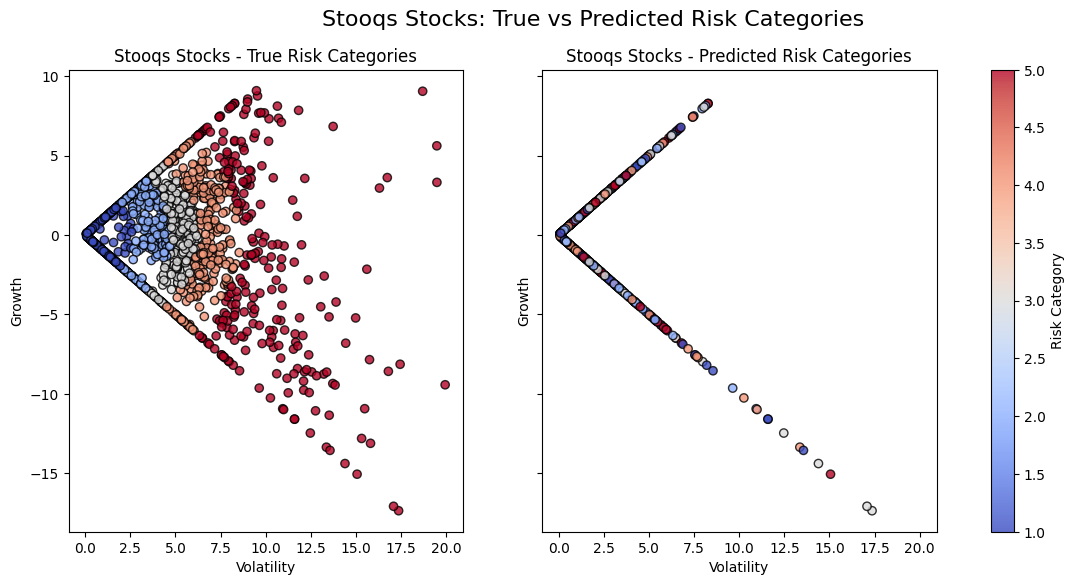

In [ ]:
### SELECT MARKET TO GENERATE VISUALIZATIONS ###

market_name = "Stooqs Stocks"
market_idx = list(y.columns).index(market_name)
y_pred_market = pd.Series(y_pred[:, market_idx], name=market_name)

plot_market_classification(market_name, X, y, risk_labels)
plot_market_prediction_vs_truth(market_name, X_test, y_test, y_pred_market)
plot_confusion_matrices(y_test, y_pred, y.columns)